In [1]:
import onnxruntime
import os
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms import ToPILImage
import torchvision.transforms as transforms
import torch
from collections import namedtuple
from scipy.special import softmax

In [2]:
# inputs
onnx_model_path = './models/onnx/'
segmentation_onnx = os.path.join(onnx_model_path, 'segmentation_full.onnx')
synthesis_onnx = os.path.join(onnx_model_path, 'synthesis.onnx')
dissimilarity_onnx = os.path.join(onnx_model_path, 'dissimilarity.onnx')

image_path = './sample_images/hanns_000001_000200_leftImg8bit.png'

In [3]:
# function for segmentations
palette = [128, 64, 128, 244, 35, 232, 70, 70, 70, 102, 102, 156, 190, 153, 153,
           153, 153, 153, 250, 170, 30,
           220, 220, 0, 107, 142, 35, 152, 251, 152, 70, 130, 180, 220, 20, 60,
           255, 0, 0, 0, 0, 142, 0, 0, 70,
           0, 60, 100, 0, 80, 100, 0, 0, 230, 119, 11, 32]
zero_pad = 256 * 3 - len(palette)
for i in range(zero_pad):
    palette.append(0)


def colorize_mask(mask):
    """
    Colorize a segmentation mask.
    """
    # mask: numpy array of the mask
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)
    return new_mask

# functions to switch between train and label ids

Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

# label2trainid
label2trainid   = { label.id      : label.trainId for label in labels   }
# trainId to label object
trainId2name   = { label.trainId : label.name for label in labels   }


trainid_to_name = trainId2name
id_to_trainid = label2trainid

In [4]:
# function for synthesis
def tensor2im(image_tensor, imtype=np.uint8, normalize=True, tile=False):
    if isinstance(image_tensor, list):
        image_numpy = []
        for i in range(len(image_tensor)):
            image_numpy.append(tensor2im(image_tensor[i], imtype, normalize))
        return image_numpy
    
    if image_tensor.dim() == 4:
        # transform each image in the batch
        images_np = []
        for b in range(image_tensor.size(0)):
            one_image = image_tensor[b]
            one_image_np = tensor2im(one_image)
            images_np.append(one_image_np.reshape(1, *one_image_np.shape))
        images_np = np.concatenate(images_np, axis=0)
        return images_np
    
    if image_tensor.dim() == 2:
        image_tensor = image_tensor.unsqueeze(0)
    image_numpy = image_tensor.detach().cpu().float().numpy()
    if normalize:
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    else:
        image_numpy = np.transpose(image_numpy, (1, 2, 0)) * 255.0
    image_numpy = np.clip(image_numpy, 0, 255)
    if image_numpy.shape[2] == 1:
        image_numpy = image_numpy[:, :, 0]
    return image_numpy.astype(imtype)
    
def get_edges(t):
    BoolTensor = torch.BoolTensor
    edge = BoolTensor(t.size()).zero_() # for PyTorch versions higher than 1.2.0, use BoolTensor instead of ByteTensor
    edge[:, :, :, 1:] = edge[:, :, :, 1:] | (t[:, :, :, 1:] != t[:, :, :, :-1])
    edge[:, :, :, :-1] = edge[:, :, :, :-1] | (t[:, :, :, 1:] != t[:, :, :, :-1])
    edge[:, :, 1:, :] = edge[:, :, 1:, :] | (t[:, :, 1:, :] != t[:, :, :-1, :])
    edge[:, :, :-1, :] = edge[:, :, :-1, :] | (t[:, :, 1:, :] != t[:, :, :-1, :])
    return edge.float()

In [5]:
# functions for dissimilarity
def one_hot_encoding(semantic, num_classes=20):
    one_hot = torch.zeros(num_classes, semantic.size(1), semantic.size(2))
    for class_id in range(num_classes):
        one_hot[class_id,:,:] = (semantic.squeeze(0)==class_id)
    one_hot = one_hot[:num_classes-1,:,:]
    return one_hot

In [6]:
# load models in onnxruntime
segmentation_session = onnxruntime.InferenceSession(segmentation_onnx)
synthesis_session = onnxruntime.InferenceSession(synthesis_onnx)
dissimilarity_session = onnxruntime.InferenceSession(dissimilarity_onnx)

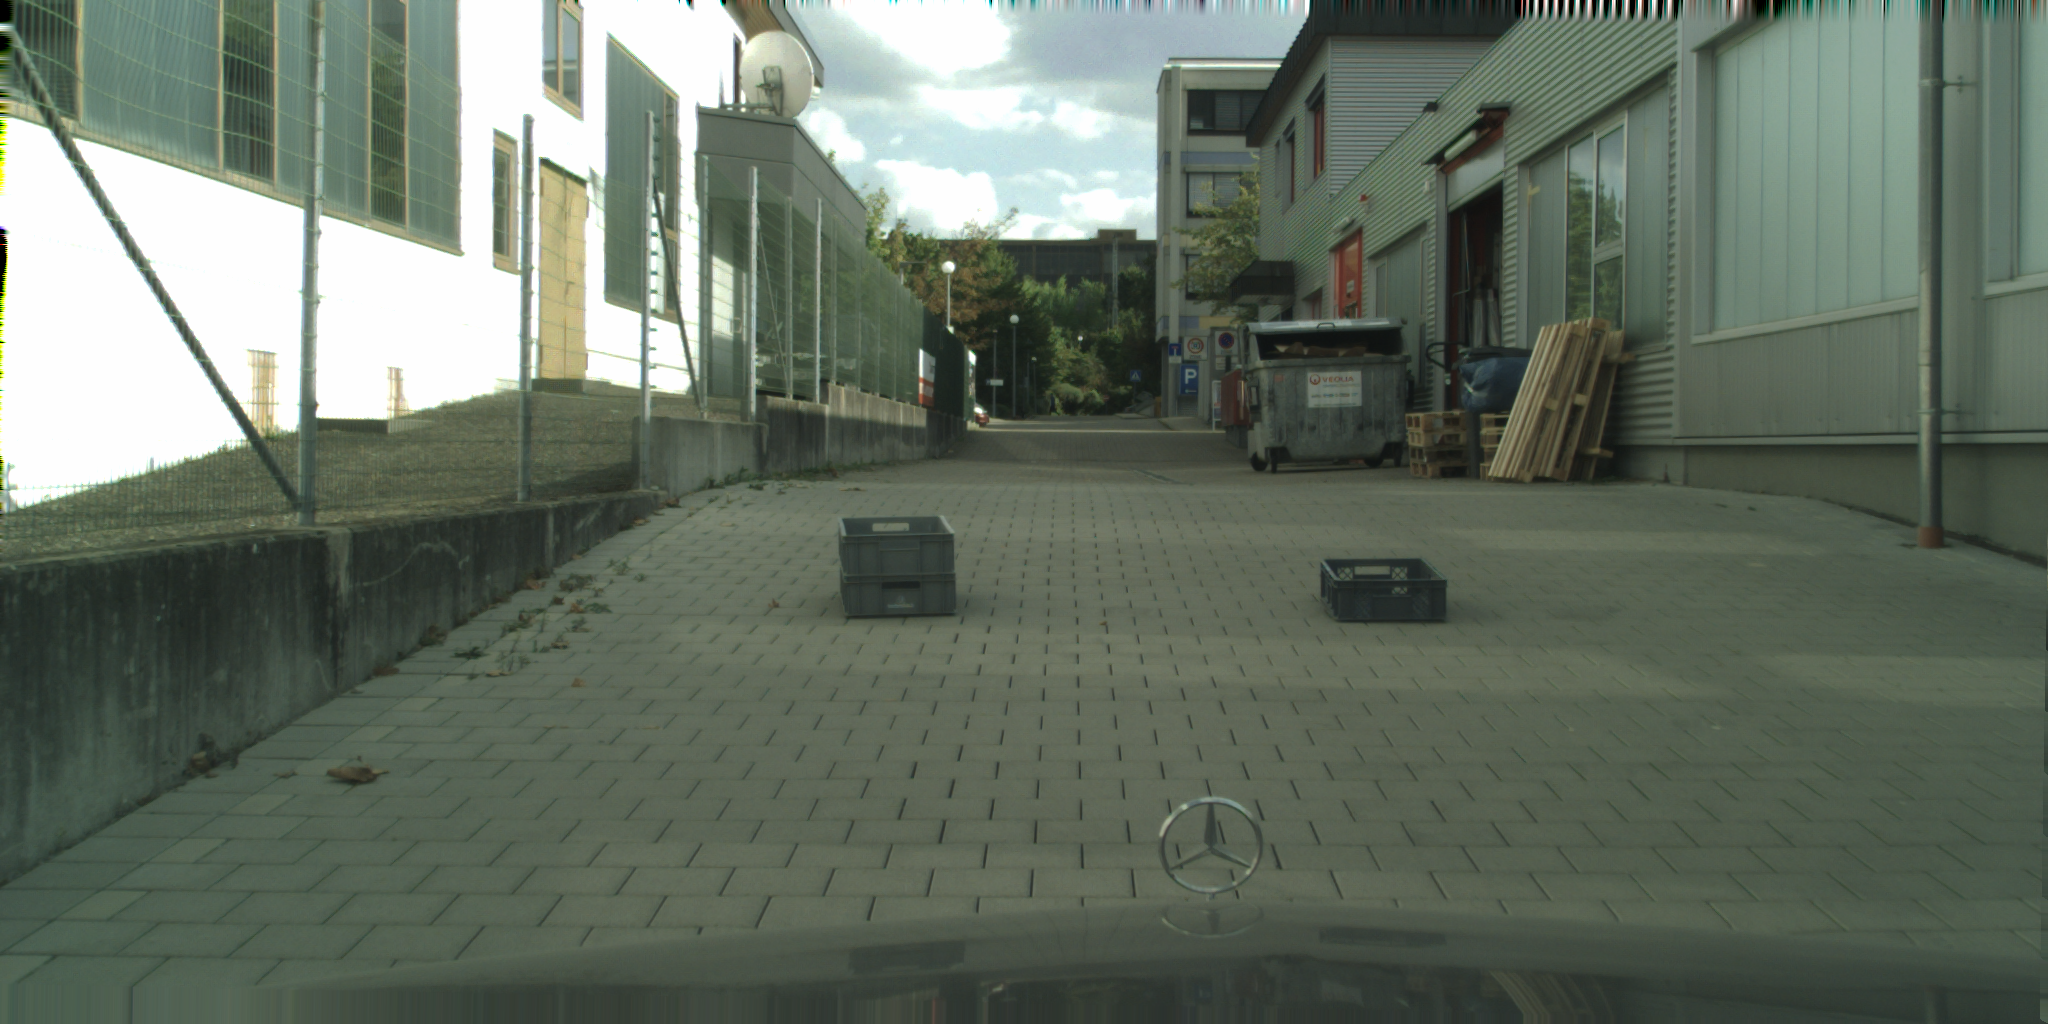

In [7]:
# pre-process image
# get data
mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
img_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*mean_std)])
img_og = Image.open(image_path).convert('RGB').resize((2048,1024))
img = img_transform(img_og).numpy()
display(img_og)

## Get Segmentation

In [8]:
# Run Segmentation
# add bacth size
input_img = np.expand_dims(np.array(img, dtype=np.float32), axis=0)
# correct axis
#input_img = np.rollaxis(input_img, 3, 1)  
seg_inputs = {segmentation_session.get_inputs()[0].name: input_img}
seg_outs = segmentation_session.run(None, seg_inputs)

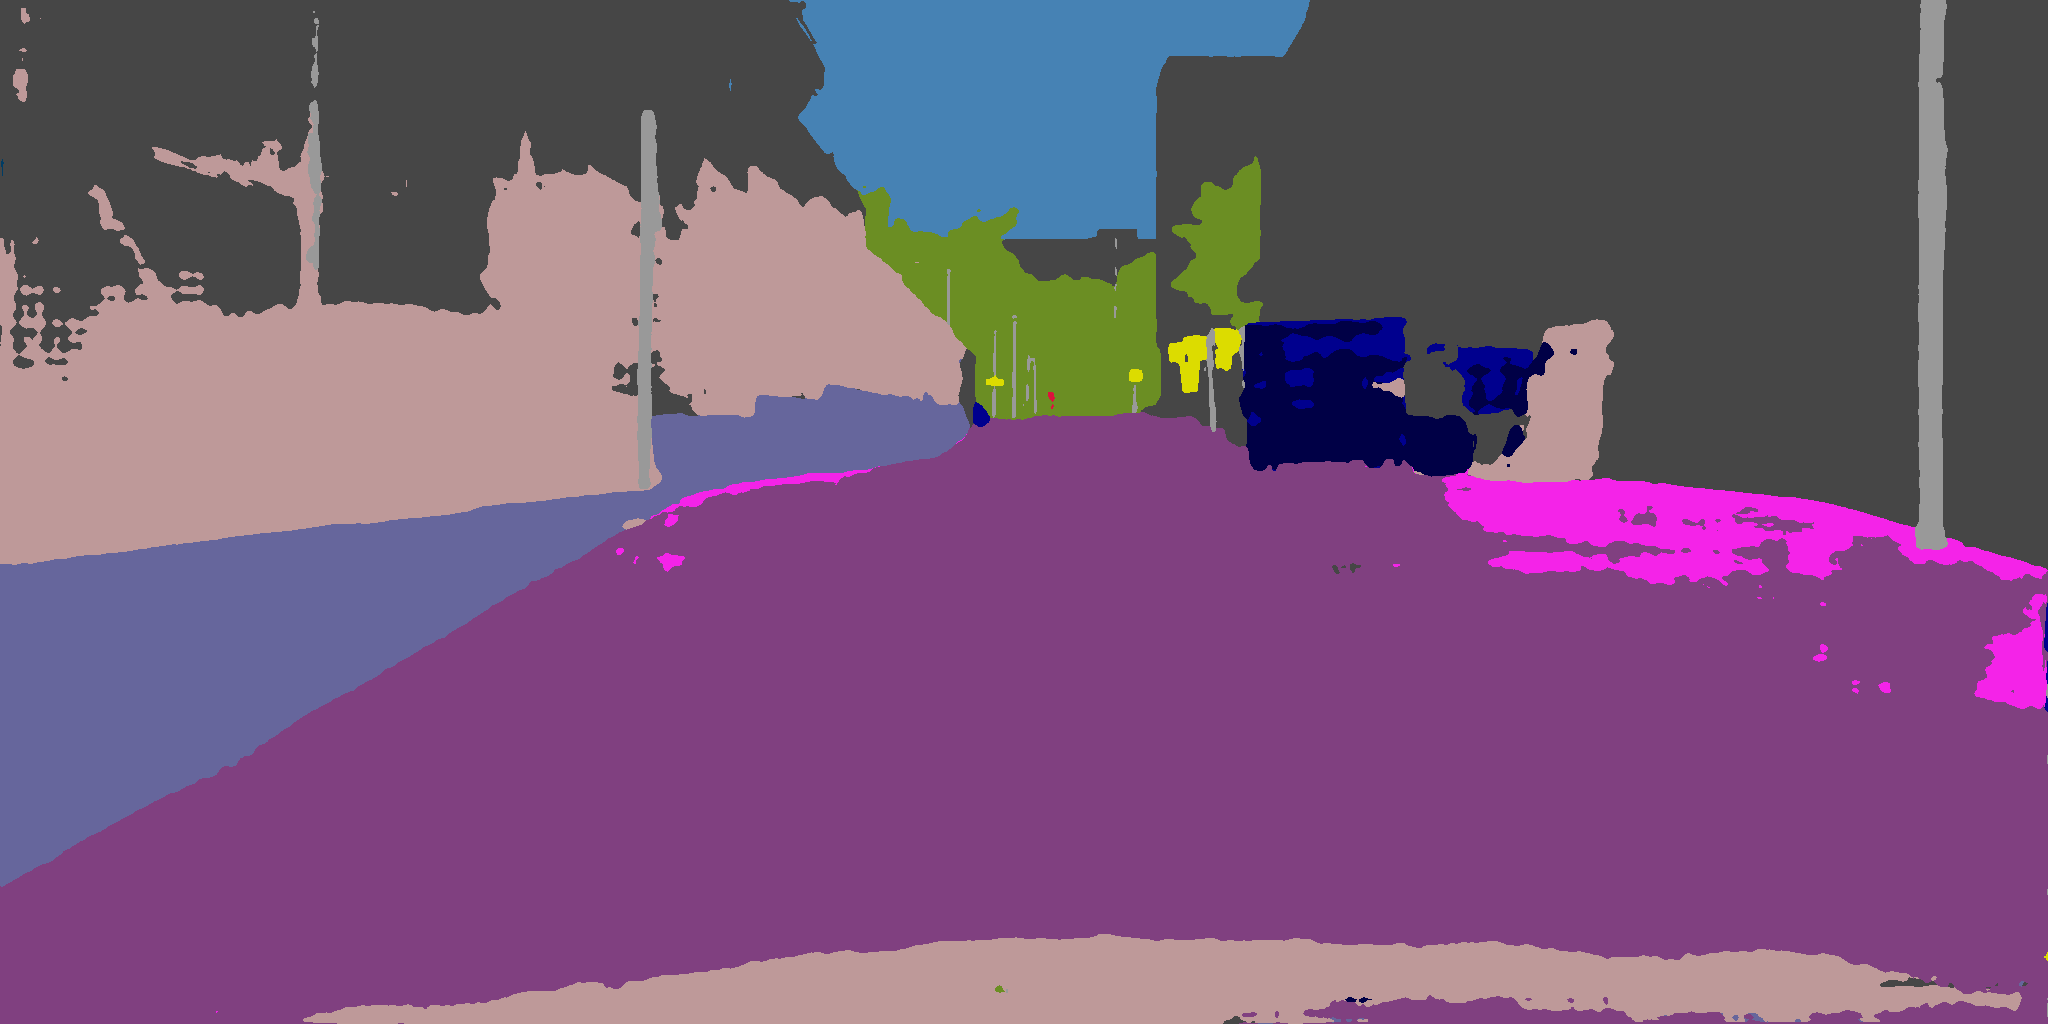

In [9]:
# Get colorized Semantic Map
seg_final = np.argmax(seg_outs[0].squeeze(), axis=0)
semantic = np.asarray(seg_final)
semantic = colorize_mask(semantic)
semantic = semantic.convert('RGB')
display(semantic)

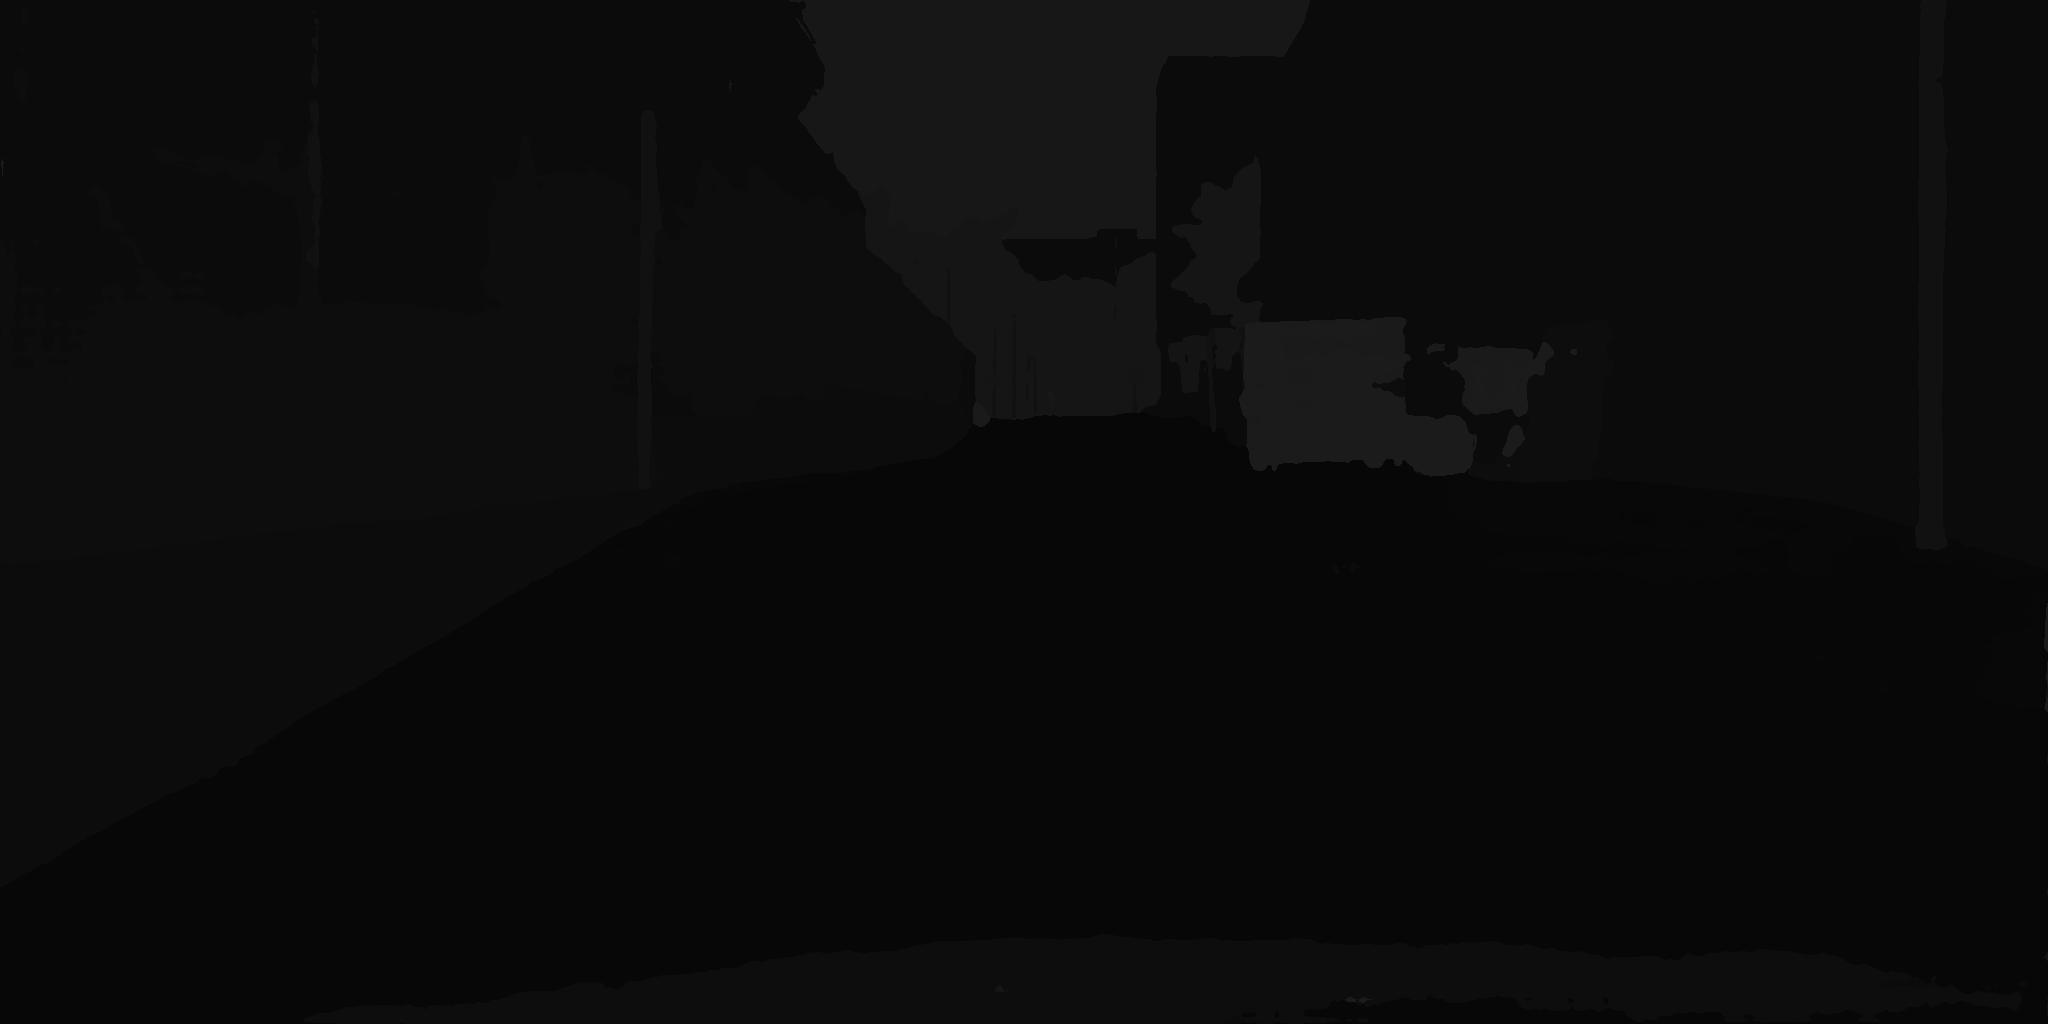

In [263]:
# Get Label ID Map
label_out = np.zeros_like(seg_final)
for label_id, train_id in id_to_trainid.items():
    label_out[np.where(seg_final == train_id)] = label_id
label_img = Image.fromarray((label_out).astype(np.uint8))
display(label_img)

## Get Synthesis Image

In [264]:
# Get synthesis image
image_size = (256,512)

# Get semantic map in right format
transform_label = transforms.Compose([transforms.Resize(size=image_size, interpolation=Image.NEAREST),transforms.ToTensor()])
label_tensor = transform_label(label_img) * 255.0
label_tensor[label_tensor == 255] = 35  # 'unknown' is opt.label_nc

# Get image map in right format
transform_image = transforms.Compose([transforms.Resize(size=image_size, interpolation=Image.BICUBIC),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))])
image_tensor = transform_image(img_og)

# Get instance map in right format. Since prediction doesn't have instance map, we use semantic instead
instance_tensor = transform_label(label_img) * 255
instance_tensor = instance_tensor.long()

In [265]:
# create one-hot label map
label_tensor = label_tensor.unsqueeze(0)
bs, _, h, w = label_tensor.long().size()
nc = 35
FloatTensor = torch.FloatTensor

input_label = FloatTensor(bs, nc, h, w).zero_()
input_semantics = input_label.scatter_(1, label_tensor.long(), 1.0)

instance_edge_map = get_edges(instance_tensor.unsqueeze(0))
input_semantics = torch.cat((input_semantics, instance_edge_map), dim=1)

In [266]:
input_feeds = {}
input_feeds[synthesis_session.get_inputs()[0].name] = input_semantics.cpu().numpy()
input_feeds[synthesis_session.get_inputs()[1].name] = image_tensor.unsqueeze(0).cpu().numpy()

synthesis_outs = synthesis_session.run(None, input_feeds)

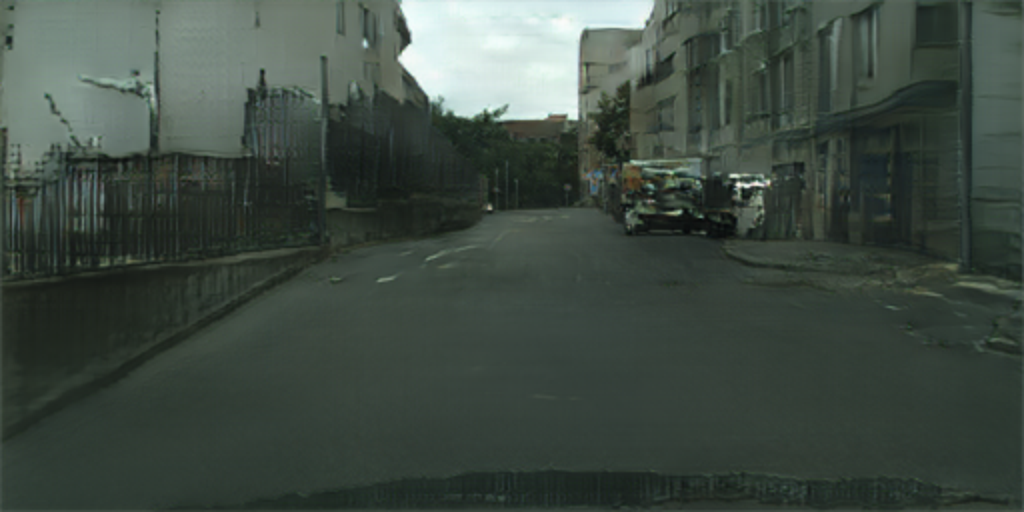

In [267]:
synthesis_outs_single = np.squeeze(synthesis_outs[0])
image_numpy = (np.transpose(synthesis_outs_single, (1, 2, 0)) + 1) / 2.0
synthesis_final_img = Image.fromarray((image_numpy * 255).astype(np.uint8))
display(synthesis_final_img.resize((1024, 512)))

# Get Dissimilarity

In [268]:
# get semantic map in train ids
semantic = Image.fromarray((seg_final).astype(np.uint8))
image = img_og
syn_image = synthesis_final_img

# for newer models we have to add normalization
base_transforms = transforms.Compose([transforms.Resize(size=image_size, interpolation=Image.NEAREST),transforms.ToTensor()])

semantic_tensor = base_transforms(semantic)*255
syn_image_tensor = base_transforms(syn_image)
image_tensor = base_transforms(image)

# hot encode semantic map
semantic_tensor[semantic_tensor == 255] = 20  # 'ignore label is 20'
semantic_tensor = one_hot_encoding(semantic_tensor, 20)

In [269]:
input_feeds = {}
input_feeds[dissimilarity_session.get_inputs()[0].name] = image_tensor.unsqueeze(0).cpu().numpy()
input_feeds[dissimilarity_session.get_inputs()[1].name] = syn_image_tensor.unsqueeze(0).cpu().numpy()
input_feeds[dissimilarity_session.get_inputs()[2].name] = semantic_tensor.unsqueeze(0).cpu().numpy()
diss_outs = dissimilarity_session.run(None, input_feeds)

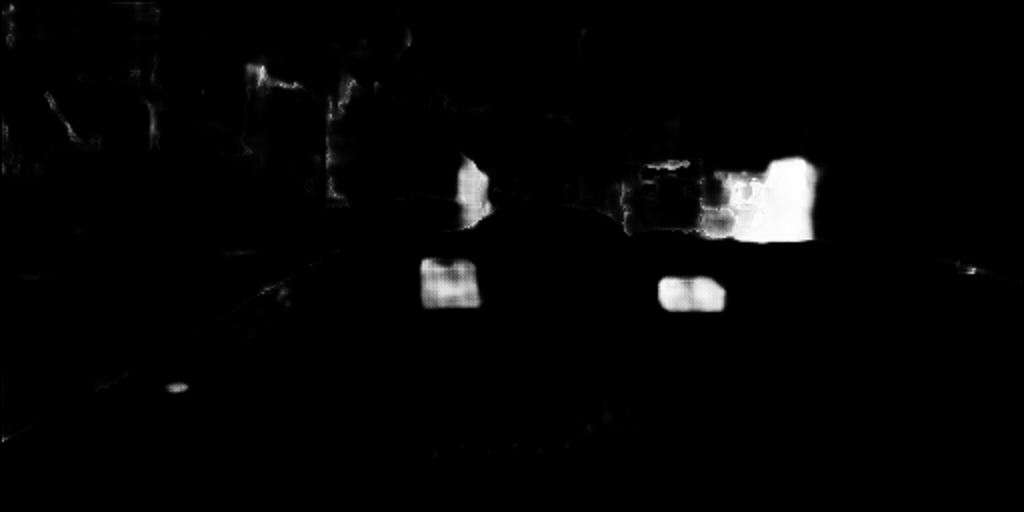

In [270]:
outputs = softmax(diss_outs[0], axis=1)
soft_pred = outputs[:,1,:,:]
soft_pred = (soft_pred * 255).astype(np.uint8)
soft_img = Image.fromarray(soft_pred.squeeze())
display(soft_img.resize((1024, 512)))